In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evoman.environment import Environment
from controller_custom import player_controller
# from evoman.controller import Controller
from multiprocessing import Pool
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd
import warnings

pygame 2.6.0 (SDL 2.28.4, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
results_EA1_EG1 = pd.read_csv('results\\results_EA1_EG1.csv')
results_EA2_EG1 = pd.read_csv('results\\results_EA2_EG1_v2.csv')
results_EA1_EG2 = pd.read_csv('results\\results_EA1_EG2.csv')
results_EA2_EG2 = pd.read_csv('results\\results_EA2_EG2_v2.csv')

# Do the same here for group 2

In [3]:
# Concatenate dataframes (stack them)
results_group1 = pd.concat([results_EA1_EG1, results_EA2_EG1])
results_group2 = pd.concat([results_EA1_EG2, results_EA2_EG2])
results_all = pd.concat([results_group1, results_group2])

In [4]:
results_all

,Algorithm,Enemy Group,Run,Generation,Mean Fitness,Max Fitness,Best Solution
0,A,1,1,0,-3.439859,21.508035,[-0.1403258 0.12566047 -0.98774271 0.218824...
1,A,1,1,1,-0.478503,30.328724,[-0.1403258 0.12566047 -0.98774271 0.218824...
2,A,1,1,2,2.079458,42.692015,[-0.1403258 0.12566047 -0.98774271 0.218824...
3,A,1,1,3,3.460673,42.692015,[-0.1403258 0.12566047 -0.98774271 0.218824...
4,A,1,1,4,5.825666,46.580940,[-0.1403258 0.12566047 -0.98774271 0.218824...
...,...,...,...,...,...,...,...
995,B,2,10,45,72.179632,72.379943,[ 1. -0.18317663 -0.07484314 -0.176952...
996,B,2,10,46,72.182450,72.379943,[ 1. -0.18317663 -0.07484314 -0.176952...
997,B,2,10,47,72.183404,72.379943,[ 1. -0.18317663 -0.07484314 -0.176952...
998,B,2,10,48,72.185811,72.379943,[ 1. -0.18317663 -0.07484314 -0.176952...


In [5]:
# Group by Algorithm, Enemy, Generation and compute mean and std
grouped = results_all.groupby(['Algorithm', 'Enemy Group', 'Generation']).agg(
    mean_fitness_mean=('Mean Fitness', 'mean'),
    mean_fitness_std=('Mean Fitness', 'std'),
    max_fitness_mean=('Max Fitness', 'mean'),
    max_fitness_std=('Max Fitness', 'std'),
).reset_index()

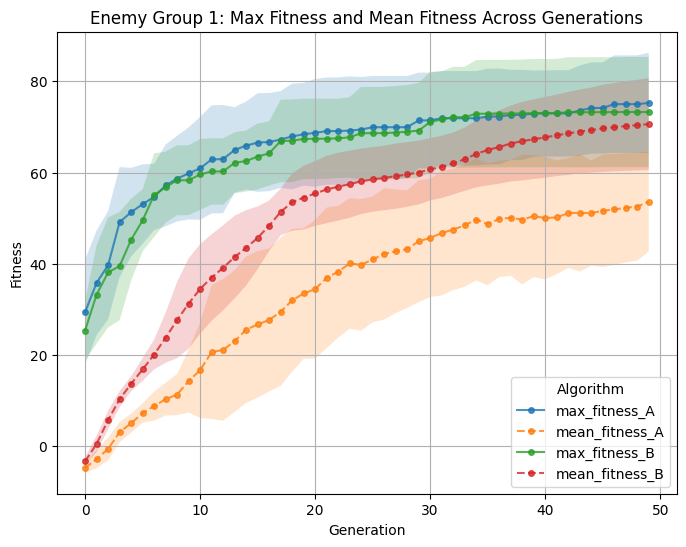

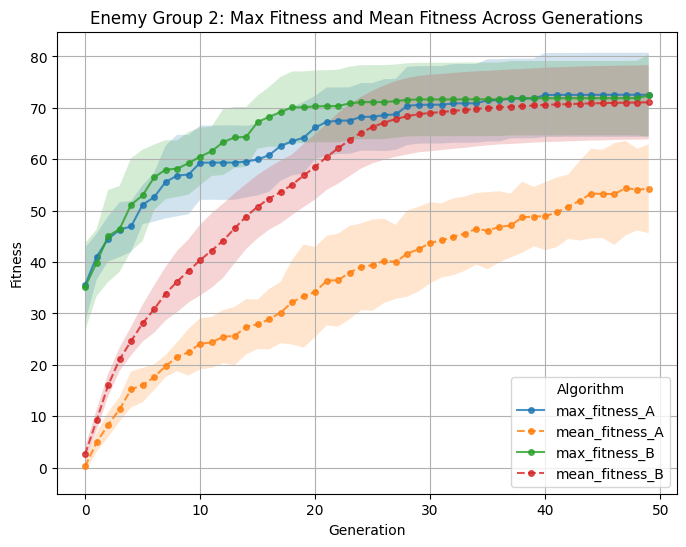

In [6]:
enemy_groups = [1,2]
for enemy_group in enemy_groups:
    plt.figure(figsize=(8, 6))
    data_enemy = grouped[grouped['Enemy Group'] == enemy_group]

    algorithms = data_enemy['Algorithm'].unique()

    for algorithm in algorithms:
        data_alg = data_enemy[data_enemy['Algorithm'] == algorithm]

        # Max Fitness
        plt.plot(
            data_alg['Generation'], 
            data_alg['max_fitness_mean'], 
            label=f'max_fitness_{algorithm}', 
            marker='o',
            markersize=4,
            alpha = 0.8
        )
        # Max Fitness Std
        plt.fill_between(
            data_alg['Generation'],
            data_alg['max_fitness_mean'] - data_alg['max_fitness_std'],
            data_alg['max_fitness_mean'] + data_alg['max_fitness_std'],
            alpha=0.2
        )
        
        # Mean Fitness
        plt.plot(
            data_alg['Generation'], 
            data_alg['mean_fitness_mean'], 
            label=f'mean_fitness_{algorithm}', 
            marker='o', 
            linestyle='--',
            markersize=4,
            alpha = 0.8
        )

        # Mean Fitness Std
        plt.fill_between(
            data_alg['Generation'],
            data_alg['mean_fitness_mean'] - data_alg['mean_fitness_std'],
            data_alg['mean_fitness_mean'] + data_alg['mean_fitness_std'],
            alpha=0.2
        )

    plt.title(f'Enemy Group {enemy_group}: Max Fitness and Mean Fitness Across Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.grid()
    plt.legend(title='Algorithm')

    plt.show()

In [7]:
def parse_solution_string(solution_string):
    cleaned_string = solution_string.replace('[', '').replace(']', '').replace(',', ' ')
    return list(map(float, cleaned_string.split()))


In [8]:
def calculate_gain(solution, enemy_group, experiment_name, n_hidden_neurons, num_tests=5):
    # Create the directory if it does not exist
    os.makedirs(experiment_name, exist_ok=True)
    solution = np.array(solution)
    
    env = Environment(
        experiment_name=experiment_name,
        enemies=enemy_group,
        playermode="ai",
        multiplemode="yes",
        player_controller=player_controller(n_hidden_neurons),
        enemymode="static",
        level=2,
        speed="fastest",
        visuals=False
    )
    
    gains = []
    for _ in range(num_tests):
            # Initialize the environment
        num_sensors = env.get_num_sensors()
        env.player_controller.set(solution, num_sensors)
        f, p_e, e_e, _ = env.play(pcont=solution)
        gain = p_e - e_e
        print(f'Gain: {gain:.4f}')
        gains.append(gain)
    
    return gains


In [9]:
results_all['Best Solution'] = results_all['Best Solution'].apply(parse_solution_string)

In [10]:
results_best = results_all.loc[results_all.groupby(['Algorithm', 'Enemy Group', 'Run'])['Max Fitness'].idxmax()].drop_duplicates(subset=['Algorithm', 'Enemy Group', 'Run', 'Max Fitness'])
results_best

,Algorithm,Enemy Group,Run,Generation,Mean Fitness,Max Fitness,Best Solution
39,A,1,1,39,44.382268,67.109188,"[-0.1403258, 0.12566047, -0.98774271, 0.218824..."
39,B,1,1,39,66.737645,67.182649,"[-0.95071119, 0.4601484, -0.74551365, -0.84935..."
39,A,2,1,39,54.353861,78.155303,"[0.75888799, 0.93668391, -0.79232123, 0.036775..."
95,A,1,2,45,32.645170,61.324403,"[-0.11851666, 0.12749289, 0.17618749, 0.047340..."
95,B,1,2,45,84.873194,86.184220,"[0.02134478, 0.77524003, 0.55046784, -0.984099..."
...,...,...,...,...,...,...,...
794,B,2,6,44,79.837902,80.178352,"[-0.567863369, 0.811335869, 0.343689782, -0.00..."
828,B,2,7,28,66.174047,72.281615,"[0.49552043, -0.54084377, 0.49960535, -0.16575..."
874,B,2,8,24,53.974365,56.258641,"[-0.9281673, -0.68634146, -0.69984985, -0.1886..."
949,B,2,9,49,79.382671,84.526495,"[0.89640273, 0.28577677, 0.89045919, 0.4954676..."


In [10]:
results_best = results_all.loc[results_all.groupby(['Algorithm', 'Enemy Group', 'Run'])['Max Fitness'].idxmax()]
results_best

,Algorithm,Enemy Group,Run,Generation,Mean Fitness,Max Fitness,Best Solution
39,A,1,1,39,44.382268,67.109188,"[-0.1403258, 0.12566047, -0.98774271, 0.218824..."
39,B,1,1,39,66.737645,67.182649,"[-0.95071119, 0.4601484, -0.74551365, -0.84935..."
39,A,2,1,39,54.353861,78.155303,"[0.75888799, 0.93668391, -0.79232123, 0.036775..."
39,A,2,1,39,54.353861,78.155303,"[0.75888799, 0.93668391, -0.79232123, 0.036775..."
95,A,1,2,45,32.645170,61.324403,"[-0.11851666, 0.12749289, 0.17618749, 0.047340..."
...,...,...,...,...,...,...,...
794,B,2,6,44,79.837902,80.178352,"[-0.567863369, 0.811335869, 0.343689782, -0.00..."
828,B,2,7,28,66.174047,72.281615,"[0.49552043, -0.54084377, 0.49960535, -0.16575..."
874,B,2,8,24,53.974365,56.258641,"[-0.9281673, -0.68634146, -0.69984985, -0.1886..."
949,B,2,9,49,79.382671,84.526495,"[0.89640273, 0.28577677, 0.89045919, 0.4954676..."


In [11]:
results = []
enemy_group_all = [1, 2, 3, 4, 5, 6, 7, 8]

for (algorithm, enemy_group_index), group in results_best.groupby(['Algorithm', 'Enemy Group']):
    i = 0 
    for solution in group['Best Solution']:
        experiment_name_gain = f'gains_{algorithm}_enemy_{enemy_group_index}'
        print(algorithm, enemy_group_index)
        print(solution)
        average_gain = calculate_gain(solution, enemy_group_all, experiment_name_gain, n_hidden_neurons=10, num_tests=5)
        
        
        results.append({
            'Algorithm': algorithm,
            'Enemy Group': enemy_group_index,
            'Gain': average_gain
        })


results_df = pd.DataFrame(results)



A 1
[-0.1403258, 0.12566047, -0.98774271, 0.21882448, -0.73723109, 0.84584459, -0.86944648, -0.80476248, 0.92552946, 0.47882291, 0.96871198, 0.16864446, 0.87705398, 0.17866329, -0.75886197, -0.92010405, -0.40089171, 0.76824389, 0.41721994, -0.20251245, -0.81886075, -0.24979985, 0.67528776, -0.32203881, -0.69468367, 0.16561011, 0.05063653, 0.82354769, -0.07509054, -0.44785618, -0.14504006, -0.28943205, -0.20530797, 0.59710336, 0.59560474, 0.10968438, -0.97725327, -0.58250824, 0.24548255, 0.99362188, -0.88754514, 0.02960272, 0.70159876, -0.45702673, 0.75240855, -0.84606163, 0.3099326, 0.64251884, 0.28425829, 0.44064835, 0.3478889, 0.22524133, -0.09230045, 0.58457702, 0.39206281, 0.45436414, -0.7840751, 0.33448966, 0.70663437, 0.32433071, 0.51602964, -0.16389018, 0.44835607, 0.22323256, 0.58396777, 0.98057034, 0.95204032, 0.97541162, -0.34124387, 0.88228067, 0.69459349, 0.36860871, 0.68069636, 0.59729254, -0.35497199, 0.93887875, 0.63899137, -0.93981218, -0.19061456, 0.5618305, -0.9788739

<Figure size 1000x600 with 0 Axes>

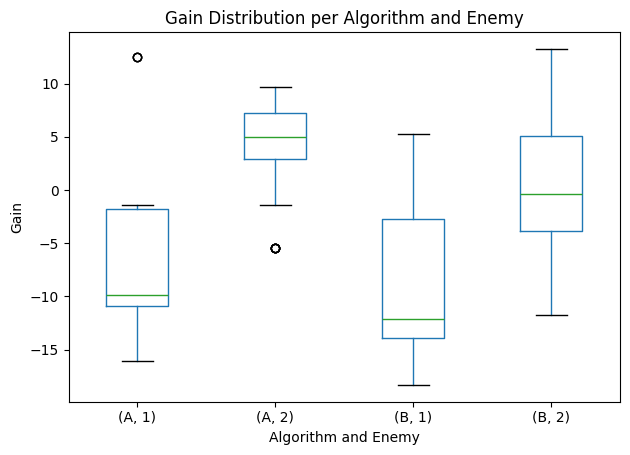

In [12]:
# Create a boxplot for the gains
plt.figure(figsize=(10, 6))
results_df.boxplot(column='Gain', by=['Algorithm', 'Enemy Group'], grid=False)

# Set plot labels and title
plt.title('Gain Distribution per Algorithm and Enemy')
plt.suptitle('') 
plt.xlabel('Algorithm and Enemy')
plt.ylabel('Gain')

# Display the plot
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
for enemy_group in enemy_groups:
    # Extract gains for each algorithm
    gains_a = results_df[(results_df['Enemy Group'] == enemy_group) & (results_df['Algorithm'] == 'A')]['Gain']
    gains_b = results_df[(results_df['Enemy Group'] == enemy_group) & (results_df['Algorithm'] == 'B')]['Gain']
    
    # Perform t-test
    if gains_a.empty or gains_b.empty:
        print(f"\nNot enough data to perform tests for Enemy {enemy_group}.")
        continue
    
    t_stat, p_val_t = ttest_ind(gains_a, gains_b, equal_var=False)
    
    # Perform Mann-Whitney U test
    u_stat, p_val_u = mannwhitneyu(gains_a, gains_b, alternative='two-sided')
    
    print(f"\nStatistical Test Results for Enemy {enemy_group}:")
    print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_val_t:.4f}")
    print(f"Mann-Whitney U test: U-statistic = {u_stat}, p-value = {p_val_u:.4f}")
    
    if p_val_t < 0.05:
        print("Result: Significant difference in mean gains (t-test).")
    else:
        print("Result: No significant difference in mean gains (t-test).")
        
    if p_val_u < 0.05:
        print("Result: Significant difference in mean gains (Mann-Whitney U test).")
    else:
        print("Result: No significant difference in mean gains (Mann-Whitney U test).")



Statistical Test Results for Enemy 1:
T-test: t-statistic = 1.0877, p-value = 0.2813
Mann-Whitney U test: U-statistic = 567.0, p-value = 0.0847
Result: No significant difference in mean gains (t-test).
Result: No significant difference in mean gains (Mann-Whitney U test).

Statistical Test Results for Enemy 2:
T-test: t-statistic = 1.4039, p-value = 0.1904
Mann-Whitney U test: U-statistic = 390.0, p-value = 0.1319
Result: No significant difference in mean gains (t-test).
Result: No significant difference in mean gains (Mann-Whitney U test).


# Gain


In [14]:
def calculate_gain(solution, enemy_group, experiment_name, n_hidden_neurons, num_tests=5):
    # Create the directory if it does not exist
    os.makedirs(experiment_name, exist_ok=True)
    solution = np.array(solution)
    
    env = Environment(
        experiment_name=experiment_name,
        enemies=enemy_group,
        playermode="ai",
        player_controller=player_controller(n_hidden_neurons),
        enemymode="static",
        level=2,
        speed="fastest",
        visuals=False,
        randomini="yes",
        multiplemode="yes",
    )
    
    gains = []
    for _ in range(num_tests):
        num_sensors = env.get_num_sensors()
                
        env.player_controller.set(solution, num_sensors)
        f, p_e, e_e, _ = env.play(pcont=solution)
        gain = p_e - e_e
        print(f'Gain: {gain:.4f}')
        gains.append(gain)
    
    return gains


In [15]:
best_solution_EA1_EG1 = np.loadtxt('results\\best_solution_A_enemy_group_1.txt')
best_solution_EA2_EG1 = np.loadtxt('results\\best_solution_B_enemy_group_1.txt')
best_solution_EA1_EG2 = np.loadtxt('results\\best_solution_A_enemy_group_2.txt')
best_solution_EA2_EG2 = np.loadtxt('results\\best_solution_B_enemy_group_2.txt')

In [16]:
# Calculate the gain for the best solution of EA1 EG1 on all enemies
enemies = np.array(range(1, 9))

gains_EA1_EG1 = calculate_gain(best_solution_EA1_EG1, enemies, 'gain_EA1_EG1', 10, 10)
gains_EA2_EG1 = calculate_gain(best_solution_EA2_EG1, enemies, 'gain_EA2_EG1', 10, 10)
gains_EA1_EG2 = calculate_gain(best_solution_EA1_EG2, enemies, 'gain_EA1_EG2', 10, 10)
gains_EA2_EG2 = calculate_gain(best_solution_EA2_EG2, enemies, 'gain_EA2_EG2', 10, 10)


MESSAGE: Pygame initialized for simulation.
Gain: -21.2208
Gain: -17.7315
Gain: -16.4155
Gain: -18.1486
Gain: -22.2615
Gain: -19.4902
Gain: -29.4846
Gain: -15.1110
Gain: -24.3999
Gain: -18.1782

MESSAGE: Pygame initialized for simulation.
Gain: -20.0650
Gain: -13.9397
Gain: -27.1513
Gain: -27.6684
Gain: -21.8926
Gain: -20.7547
Gain: -25.2106
Gain: -24.3233
Gain: -25.8156
Gain: -23.3476

MESSAGE: Pygame initialized for simulation.
Gain: -10.7711
Gain: -21.8338
Gain: -14.3176
Gain: -17.0050
Gain: -18.6493
Gain: -13.3540
Gain: -17.9301
Gain: -8.3264
Gain: -23.9796
Gain: -23.3720

MESSAGE: Pygame initialized for simulation.
Gain: -11.7120
Gain: -21.6374
Gain: -24.1359
Gain: -19.1874
Gain: -5.9703
Gain: -16.2258
Gain: -15.8959
Gain: -19.6839
Gain: -14.4738
Gain: -24.4571


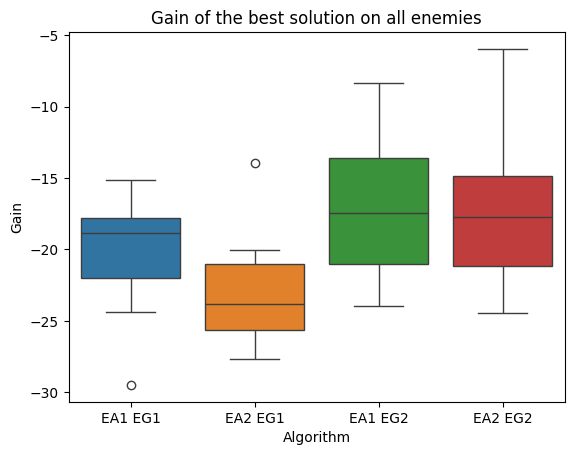

In [19]:
# make 2 boxplots of the gains
plt.figure()
sns.boxplot(data=[gains_EA1_EG1, gains_EA2_EG1, gains_EA1_EG2, gains_EA2_EG2])	# add other solutions here 
plt.xlabel('Algorithm')
plt.ylabel('Gain')
plt.title('Gain of the best solution on all enemies')
plt.xticks([0, 1, 2, 3], ['EA1 EG1', 'EA2 EG1','EA1 EG2', 'EA2 EG2'])
plt.show()


# Statistical Tests

In [20]:
# Perform a t-test
t_statistic, p_value = ttest_ind(gains_EA1_EG1, gains_EA2_EG1)
print(f'T-statistic: {t_statistic:.4f}')
print(f'P-value: {p_value:.4f}')

# Perform a Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(gains_EA1_EG1, gains_EA2_EG1)
print(f'U-statistic: {u_statistic:.4f}')
print(f'P-value: {p_value:.4f}')




T-statistic: 1.4804
P-value: 0.1561
U-statistic: 70.0000
P-value: 0.1405
